In [1]:
import os
import sys
import time
import random
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import contextlib
import logging
import openbabel
from openbabel import pybel
import rdkit

from random import randrange
from rdkit import Chem, RDLogger
from rdkit.Chem import MolFromSmiles as smi2mol
from rdkit.Chem import MolToSmiles as mol2smi
from rdkit.Chem import AllChem, rdMolAlign, Descriptors, Draw
from rdkit.Chem.rdchem import Mol
from rdkit.DataStructs.cDataStructs import TanimotoSimilarity
from rdkit.Chem import rdFMCS, MolFromSmarts
from selfies import encoder, decoder 
from rdkit.Chem.Draw import MolToImage, IPythonConsole, rdMolDraw2D

import lomap

# Get the current working directory
current_dir = os.getcwd()

# Get the absolute path to the parent directory
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add the parent directory to sys.path
sys.path.insert(0, parent_dir)

# Now you can import the module
from generator import fingerprint
from generator import generation
from generator import filters
from generator import scoring
from generator import visualization

In [2]:
def find_mcs(smiles_1, smiles_2):
    """
    Find the maximum common substructure (MCS) of two molecules.
    
    Args:
    smiles_1, smiles_2 (str): SMILES strings of the two molecules.
    
    Returns:
    rdkit.Chem.rdchem.Mol: The MCS of the two molecules.
    """
    mol_a = Chem.MolFromSmiles(smiles_1)
    mol_b = Chem.MolFromSmiles(smiles_2)

    mcs = rdFMCS.FindMCS([mol_a, mol_b],
                         atomCompare=rdFMCS.AtomCompare.CompareElements,
                         bondCompare=rdFMCS.BondCompare.CompareAny,
                         matchValences=False,
                         ringMatchesRingOnly=True,
                         completeRingsOnly=True,
                         matchChiralTag=False,
                         timeout=2)
    template = Chem.MolFromSmarts(mcs.smartsString)

    return template

In [3]:
# get 2 smiles molecules
# calculate MCS
# only generate intermediates for R-group # check if this is nessacery, it used to be really reliable for full molecules
# re-Glue to molecule



In [28]:
from rdkit import Chem

def sdf_to_smiles(sdf_file):
    # Open the SDF file
    suppl = Chem.SDMolSupplier(sdf_file)
    
    # List to store SMILES strings
    smiles_list = []
    
    # Iterate over molecules in the SDF file
    for mol in suppl:
        if mol is not None:
            # Convert molecule to SMILES string
            smiles = Chem.MolToSmiles(mol)
            smiles_list.append(smiles)
    
    return smiles_list

# Example usage
sdf_file = '../data/ligands/tyk2/lig_ejm_49.sdf'  # Replace with your SDF file path
smiles_strings = sdf_to_smiles(sdf_file)
for smiles in smiles_strings:
    print(smiles)

O=C(Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1)c1ccccc1


In [5]:
liga_smiles = "CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-31
ligb_smiles = "CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1" #tyk2-44
num_tries = 10
num_random_smiles = 10
collect_bidirectional = True
exponent_path = 1
n_rounds = 1
fp_type = "ECFP4"

In [6]:
def generate_multiple_paths(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, exponent_path, n_rounds, fp_type):
    """
    Runs the path-based generation n amount of times, finding multiple intermediates and so increasing the size of the searched chemical space.
    
    Args:
        liga_smiles (str): The SMILES representation of the first ligand.
        ligb_smiles (str): The SMILES representation of the second ligand.
        num_tries (int): The number of attempts for the path generation process.
        num_random_smiles (int): The number of random SMILES to be generated.
        collect_bidirectional (bool): Flag to determine if bidirectional path generation is considered.
        n_rounds (int): The number of rounds to perform the path-based generation.
        fp_type (str): The fingerprint type used in scoring molecules.

    Returns:
        list: The list of unique top-scoring intermediates.
    """    
    # create list for multiple intermed_smiles
    intermed_smiles_list = []
    for _ in range(n_rounds):
        top_intermediate = generation.generation_path(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, exponent_path, fp_type=fp_type)
        intermed_smiles_list.append(top_intermediate)
        print(top_intermediate)
        
    intermed_smiles = filters.drop_duplicates(liga_smiles, ligb_smiles, intermed_smiles_list)
    print('Number of unique top1-scoring intermediates: ',len(intermed_smiles))
    
    return intermed_smiles

In [7]:
generate_multiple_paths(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, exponent_path, n_rounds, fp_type)

total number of path based generated intermediates:  31900
total number of path based generated intermediates after filters:  9
CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1
Number of unique top1-scoring intermediates:  1


['CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1']

In [8]:
def generation_path(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, exponent_path, fp_type):
    """
    Runs the path-based generation and subsequently scores the generated molecules, returning the best predicted molecule.
    
    Args:
        liga_smiles (str): The SMILES representation of the first ligand.
        ligb_smiles (str): The SMILES representation of the second ligand.
        num_tries (int): The number of attempts for the path generation process.
        num_random_smiles (int): The number of random SMILES to be generated.
        collect_bidirectional (bool): Flag to determine if bidirectional path generation is considered.
        fp_type (str): The fingerprint type used in scoring molecules.

    Returns:
        str: The SMILES representation of the best predicted intermediate molecule.
    """
    liga = Chem.MolFromSmiles(liga_smiles)
    ligb = Chem.MolFromSmiles(ligb_smiles)
    
    # generate path
    generated_paths = generation.get_compr_paths(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, fp_type=fp_type)
    
    # flatten lists
    smiles_generated_paths = filters.flatten(generated_paths)
    print('total number of path based generated intermediates: ', len(smiles_generated_paths))

    # write smiles to mols
    mols_generated_paths = [Chem.MolFromSmiles(smi) for smi in smiles_generated_paths]

    # drop duplicates
    uniq = filters.drop_duplicates(liga_smiles, ligb_smiles, smiles_generated_paths)
    
    # apply filters path based generation
    filtered_smiles_path = filters.filters_path_based_generation(liga_smiles, ligb_smiles, uniq)
    print('total number of path based generated intermediates after filters: ', len(filtered_smiles_path))
    print(filtered_smiles_path)

    # scoring path based generation
    subset_tanimoto, best_scores = scoring.score_median_mols(liga_smiles, ligb_smiles, filtered_smiles_path, exponent_path)

    # drop duplicates 
    #subset_tanimoto = filters.drop_duplicates(liga_smiles, ligb_smiles, smiles_)

    # If subset_tanimoto is empty, return None
    if not subset_tanimoto:
        print("subset_tanimoto is empty. Skipping this iteration.")
        return None
    
    # select path based intermediate
    intermed_smiles = subset_tanimoto[0]
    
    return intermed_smiles, filtered_smiles_path

In [9]:
def visualise(liga_smiles, ligb_smiles, selected_intermediate_smiles):
    """
    Visualise and save an image of three aligned ligands with the Maximum Common Substructure (MCS) highlighted.
    
    Args:
        liga_smiles, ligb_smiles, selected_intermediate_smiles (str): The SMILES strings for the ligands to visualize.
        mins, secs (int): The minutes and seconds elapsed.
        filepath (str): The path to the location where the image is to be saved.
        filename (str): The name of the file.
    """
    # get intermediate
    liga = Chem.MolFromSmiles(liga_smiles)
    ligb = Chem.MolFromSmiles(ligb_smiles)
    intermediate = Chem.MolFromSmiles(selected_intermediate_smiles)

    # find MCS of the 3 molecules
    mcs_mol = filters.find_mcs_3_mols(liga_smiles, ligb_smiles, selected_intermediate_smiles)

    # Align ligands 
    molecules = visualization.alignLigands(liga, intermediate, ligb)

    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 1]})

    # Generate the images with the MCS highlighted
    img0 = visualization.draw_molecule_with_mcs(liga, mcs_mol)
    img1 = visualization.draw_molecule_with_mcs(intermediate, mcs_mol)
    img2 = visualization.draw_molecule_with_mcs(ligb, mcs_mol)

    # Plot the images
    axes[0].imshow(img0)
    axes[1].imshow(img1)
    axes[2].imshow(img2)


    # Turn off axes and set titles.
    titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
    for ax, title in zip(axes, titles):
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        ax.set_title(title)

    # set spacing between plots
    plt.subplots_adjust(wspace=0.08)



    plt.show()

<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
<>:37: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1043612/1686162973.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]
/tmp/ipykernel_1043612/1686162973.py:37: SyntaxWarning: invalid escape sequence '\l'
  titles = ["$\lambda = 0$", "Intermediate", "$\lambda = 1$"]


In [10]:
intermed_mol, filtered_smiles_path = generation_path(liga_smiles, ligb_smiles, num_tries, num_random_smiles, collect_bidirectional, exponent_path, fp_type)


total number of path based generated intermediates:  31900
total number of path based generated intermediates after filters:  8
['CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)(C)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)(O)C(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)NCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)CCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(O)NCCC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)NC=CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1', 'CC(C)C=CC(=O)Nc1cc(NC(=O)c2c(Cl)cccc2Cl)ccn1']


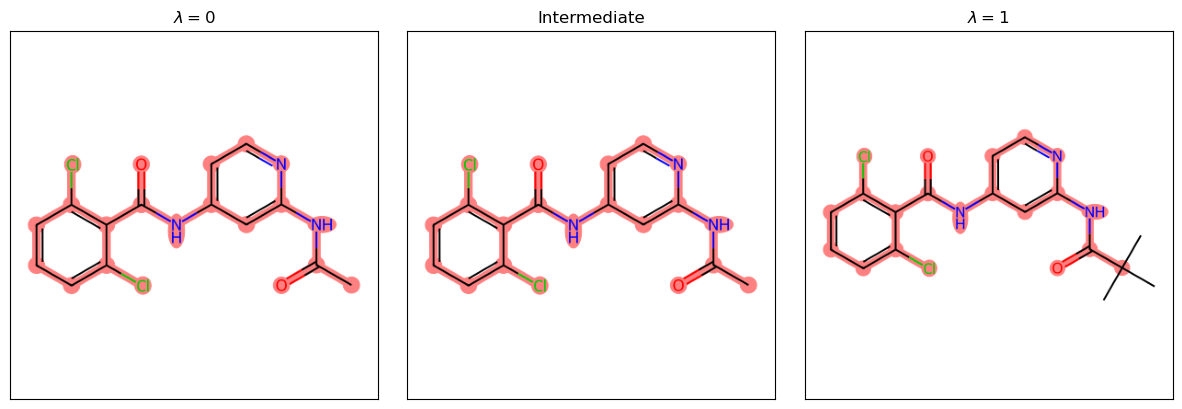

In [11]:
visualise(liga_smiles, ligb_smiles, filtered_smiles_path[0])

In [12]:
intermed_smiles = filtered_smiles_path[0]

In [13]:
num_random_samples = 1000
num_mutation_ls = [1]

generated_chemical_space = generation.generate_local_chemical_space(intermed_smiles, num_random_samples, num_mutation_ls, fp_type)

Randomized molecules (in SELFIES) time:  0.26624345779418945
Mutation obtainment time (back to smiles):  0.8092410564422607
Unique mutated structure obtainment time:  0.19576263427734375
Fingerprint calculation time:  0.16048884391784668
Total time:  1.4321699142456055


In [14]:
filtered_smiles = filters.filters_local_chemical_space_generation(liga_smiles, ligb_smiles, generated_chemical_space)
print('total number of generated local chemical space intermediates after filters for smiles-pair: ', len(filtered_smiles))
print('')

total number of generated local chemical space intermediates after filters for smiles-pair:  10



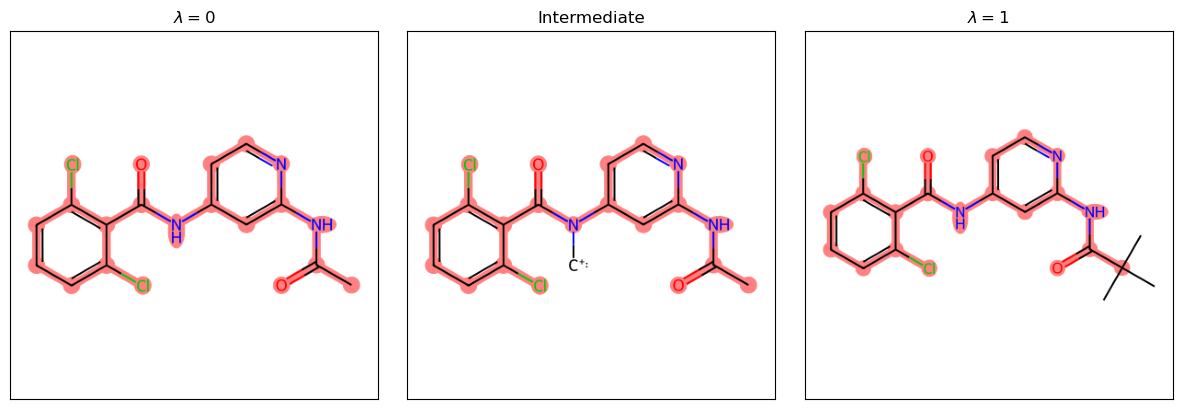

In [25]:
visualise(liga_smiles, ligb_smiles, filtered_smiles[0])